# General introduction to linear classification
Problem: given a set of data, assume that they are linearly separable and find a good boundary between the classes.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt

## Dataset
For the examples, we are going to use the [**Recipe Ingredients Dataset**](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset).

Each recipe is a collection of ingredients and the task is to guess the kind of cuisine (multi-class classification).

First, we compute some statistics on the dataset in order to find the most specific ingredients for each type of cuisine.

In [3]:
import json
from collections import defaultdict

In [4]:
train_data_file = "/Users/flint/Data/recipe/kaggle_recipes/train.json"
with open(train_data_file, 'r') as infile:
    train_json = json.load(infile)

In [5]:
cuisine = defaultdict(list)
document_frequency = defaultdict(lambda: 0)
cuisine_frequency = defaultdict(lambda: defaultdict(lambda: 0))
for recipe in train_json:
    cuisine[recipe['cuisine']].append(recipe)
    for ingredient in recipe['ingredients']:
        document_frequency[ingredient] += 1
        cuisine_frequency[recipe['cuisine']][ingredient] += 1

### Specificity of ingredients

In [6]:
kl_ingredients = defaultdict(lambda: defaultdict(lambda: 0))
N = sum(document_frequency.values())
for c, i in cuisine_frequency.items():
    T = sum(i.values())
    for x, f in i.items():
        kl_ingredients[c][x] = f / T * np.log((f / T) / (document_frequency[x] / N))

In [7]:
KL = pd.DataFrame(kl_ingredients).fillna(-1).T

In [8]:
KL.head(2)

,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles,ground pork,...,hungarian hot paprika,cooked beetroot,creamed horseradish,creamer potatoes,dark rye flour,beluga lentil,bermuda onion,snip fresh dill,wild asparagus,cocktail pumpernickel bread
greek,0.005356,0.004089,0.003057,0.000842,0.008367,0.019528,-0.000061,0.003299,0.067966,-0.000400,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
southern_us,-0.000228,-0.000144,-0.000154,-0.006338,0.003182,-0.001512,0.000100,-0.000064,-0.000177,-0.000151,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [9]:
KL.loc['greek'].sort_values(ascending=False).head(5)

feta cheese crumbles    0.067966
feta cheese             0.051712
dried oregano           0.038444
olive oil               0.034407
cucumber                0.033842
Name: greek, dtype: float64

In [10]:
KL.loc['italian'].sort_values(ascending=False).head(5)

grated parmesan cheese    0.031131
olive oil                 0.030696
extra-virgin olive oil    0.017638
fresh basil               0.013572
ground black pepper       0.009468
Name: italian, dtype: float64

In [11]:
train_json[0]['ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

## Starting with linear regression
In order to discuss linear regression, we select a type of cuisine and we create a special dataset where we have only one feature $x$ representing the fraction of that cuisine-specific ingredients in each recipe.

The target variable is an arbitrary function $f(x)$ defined over $x$. 

In [12]:
import matplotlib.pyplot as plt

In [13]:
cuisine = 'italian'
specific_ingredients = set(KL.loc[cuisine][KL.loc[cuisine] > 0].keys())
target_function = lambda x: 6 + 2 * x + np.random.randn(x.shape[0], 1)

In [14]:
sample_size = 200
X = np.zeros((sample_size, 1))
for i, recipe in enumerate(train_json[:sample_size]):
    ingredients = recipe['ingredients']
    X[i,0] = len([x for x in ingredients if x in specific_ingredients]) / len(ingredients)
y = target_function(X)

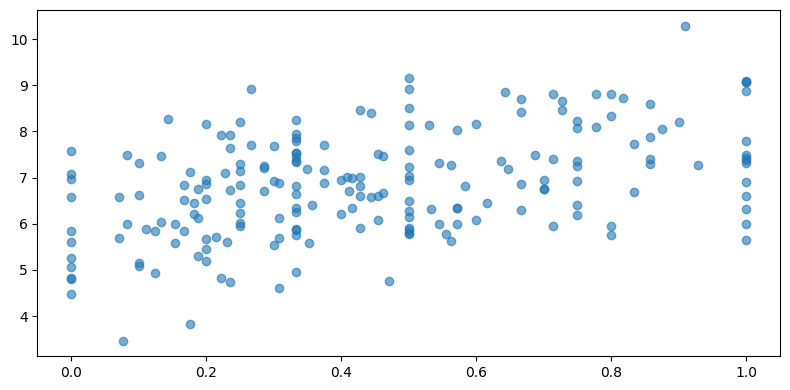

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
plt.tight_layout()
plt.show()

### Linear regression model prediction
The general form of the linear regression prediction function is:

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_{n-1} x_{n-1} + \theta_{n} x_{n}
$$

where $\theta_1 \dots \theta_n$ are weights for the features and $\theta_0$ represents a bias term.

In [16]:
theta = np.random.uniform(size=1 + X.shape[1]).reshape(-1, 1)

In [17]:
theta

array([[0.21604895],
       [0.11312998]])

In [18]:
y_hat_0 = theta[0,0] + sum([theta[i+1,0]*X[0, i] for i in range(X.shape[1])])
y_hat_0

0.29146893970858156

Let's rewrite the function in its vector form

$$
\hat{y} = \theta^T \cdot \mathbf{x}
$$

note that we can manage the free bias term by adding a special feature with value 1 to all the items

In [19]:
Xb = np.c_[np.ones((X.shape[0], 1)), X]
Xb[:2]

array([[1.        , 0.66666667],
       [1.        , 0.54545455]])

In [20]:
y_hat_0 = theta.T.dot(Xb[0])
y_hat_0

array([0.29146894])

### Geometric interpretation
The model parameters $\theta$ provide the slope and the intercept for the line that fits the points

In [21]:
example_points = np.array([
    [1, X.min()], [1, X.max()]
])
y_prediction = theta.T.dot(example_points.T)

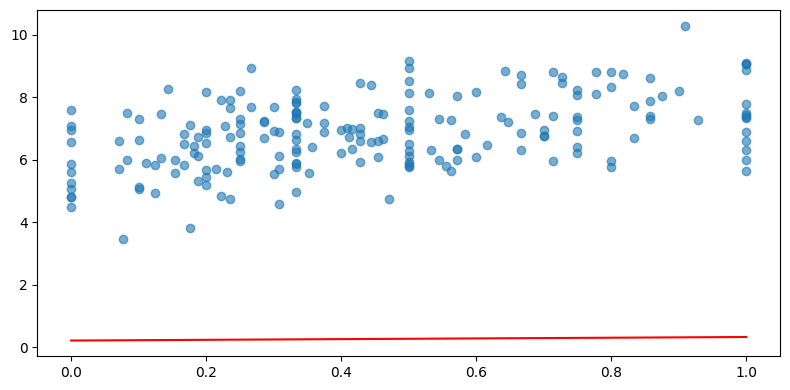

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(example_points[:,1], y_prediction[0], 'r-')
plt.tight_layout()
plt.show()

## Learning the parameters $\theta$

The optimal parameters $\theta$ that map the features $X$ to the target variable $y$ can be computed by a closed-form solution called $Normal Equation$

$$
\hat{\theta} = \left ( \mathbf{X}^T \cdot \mathbf{X} \right )^{-1} \cdot \mathbf{X}^T \cdot y
$$

In [23]:
theta_best = np.linalg.inv(Xb.T.dot(Xb)).dot(Xb.T).dot(y)

In [24]:
theta_best

array([[6.0290397 ],
       [1.85556733]])

In [25]:
example_points = np.array([
    [1, X.min()], [1, X.max()]
])
y_prediction = theta_best.T.dot(example_points.T)

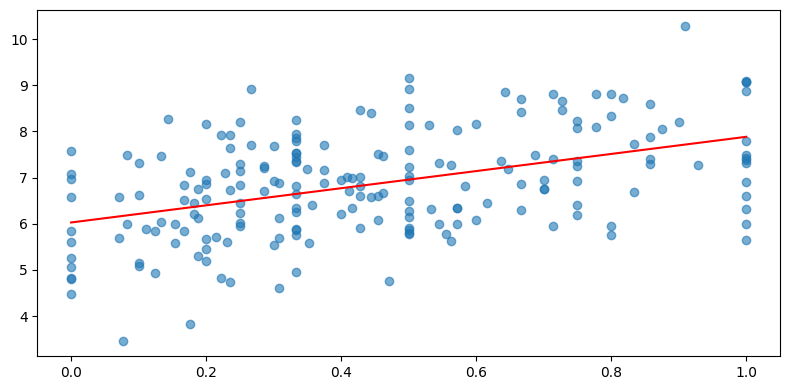

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(example_points[:,1], y_prediction[0], 'r-')
plt.tight_layout()
plt.show()

In [27]:
theta_best

array([[6.0290397 ],
       [1.85556733]])

### Complexity of the Normal Equation as a solution
The main limit of the normal equation is that it requires to compute the inverse of $\mathbf{X}^T \cdot \mathbf{X}$ that is $n \times n$, where $n$ is the number of features. Inverting such matrix as complexity that may reach $O(n^3)$. Thus, this solution is not suitable with a high number of features.

## Learning $\theta$ by Gradient Descent

As an alternative to compute the optimal values for $\theta$, we can try to learn them by finding the values that minimize the error.

### Compute prediction error by a loss function

As an example of a loss function, we can use Mean Square Error

$$
MSE(\mathbf{X}, \hat{y}) = \frac{1}{m} \sum\limits_{i=1}^{m} \left( \hat{y}^{(i}) - y^{(i)} \right)^2
$$

### Batch gradient descent
Then, we need the gradient of the loss function in order to use it for updating the parameters in the direction of the $MSE$ minimum. To compute the gradient vector, we start from the partial derivative of each parameter $\theta_j$ as follows:

$$
\frac{\partial}{\partial \theta_j} MSE(\theta) = \frac{2}{m} \sum\limits_{i=1}^{m} \left ( \theta^T \cdot \mathbf{x}^{(i)} - y^{(i)} \right ) x_{j}^{(i)}
$$

That is, in vector form:

$$
grad_{MSE} = \frac{2}{m} \mathbf{X}^T \cdot (\mathbf{X} \cdot \theta - y)
$$

Given $grad_{MSE}$ we just need to subtract it to $\theta$. However, we need to avoid an updating step too big, because we risk to skip the minimum. Thus, let's introduce a learning rate $\eta$ and do training as:

$$
\theta_{i+1} = \theta_i - \eta\ grad_{MSE}(\theta_i)
$$

In [28]:
mse = lambda theta: np.power(theta.T.dot(Xb.T)[0] - y, 2).mean()

In [29]:
eta = .1
iterations = 1000
m = Xb.shape[0]

theta = np.random.uniform(size=(Xb.shape[1], 1))

In [30]:
loss = []
history = []
for iteration in range(iterations):
    loss.append(mse(theta))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration % 20 == 0:
        history.append(theta)

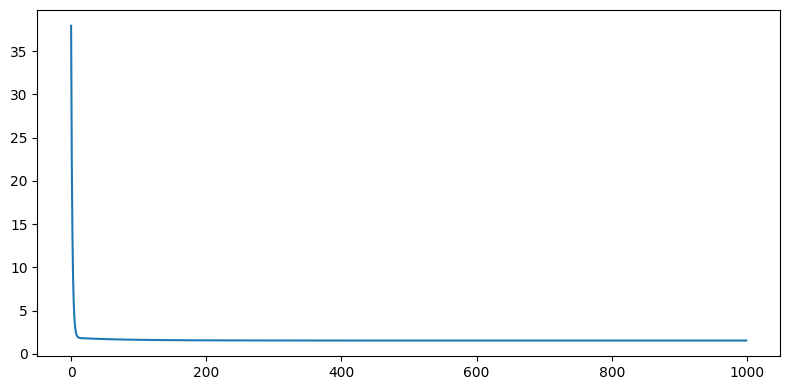

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(loss)
plt.tight_layout()
plt.show()

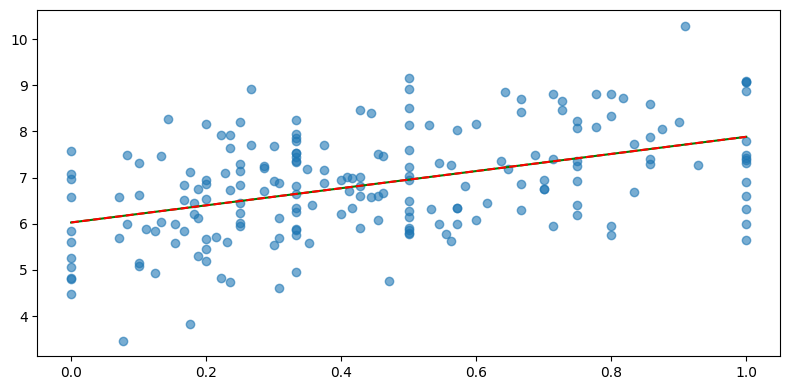

In [32]:
example_points = np.array([
    [1, X.min()], [1, X.max()]
])
y_prediction_best = theta_best.T.dot(example_points.T)
y_prediction = theta.T.dot(example_points.T)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(example_points[:,1], y_prediction_best[0], 'g-')
ax.plot(example_points[:,1], y_prediction[0], 'r--')
plt.tight_layout()
plt.show()

In [33]:
from IPython.display import clear_output
import time

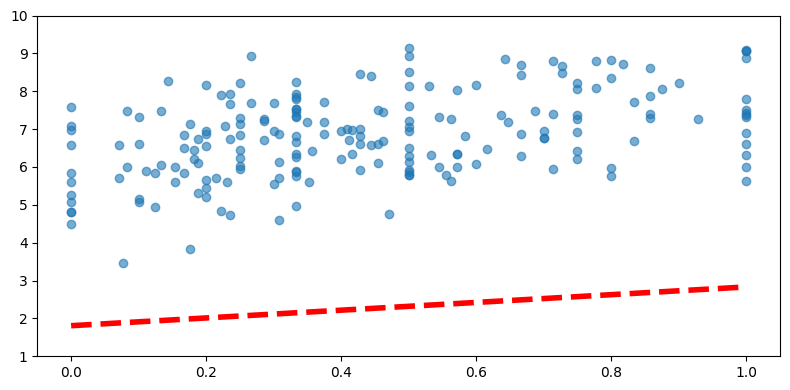

In [34]:
example_points = np.array([[1, X.min()], [1, X.max()]])
predictions = []
for th in history:
    predictions.append(th.T.dot(example_points.T))

cmd = None
for pred in predictions:
    if cmd == 'quit':
        break
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(X, y, alpha=.6)
    ax.plot(example_points[:,1], pred[0], 'r--', linewidth=4)
    ax.set_ylim((1,10))
    plt.tight_layout()
    plt.show()
    cmd = input()



## Exploit Linear regression for binary classification
In order to address binary classification, a very simple strategy is to just change the target variable in a categorical variable. In our case, we set $y \in \{-1, 1\}$, with $-1$ if the recipes is not from the selected cuisine and $1$ otherwise.

In [35]:

sample_size = 200
X, y = np.zeros((sample_size, 1)), np.ones((sample_size, 1))
for i, recipe in enumerate(train_json[:sample_size]):
    ingredients = recipe['ingredients']
    X[i,0] = len([x for x in ingredients if x in specific_ingredients]) / len(ingredients)
    if recipe['cuisine'] != cuisine:
        y[i] = -1

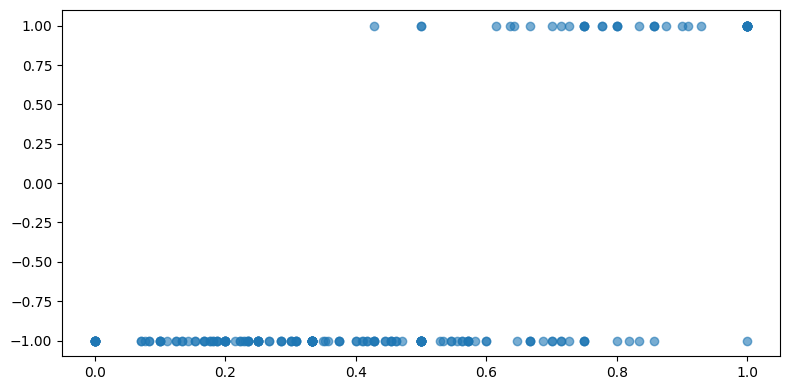

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
plt.tight_layout()
plt.show()

In [37]:
eta = 0.1
iterations = 1000
m = Xb.shape[0]
theta = np.random.uniform(size=(Xb.shape[1], 1))
loss = []
history = []
for iteration in range(iterations):
    loss.append(mse(theta))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration % 20 == 0:
        history.append(theta)

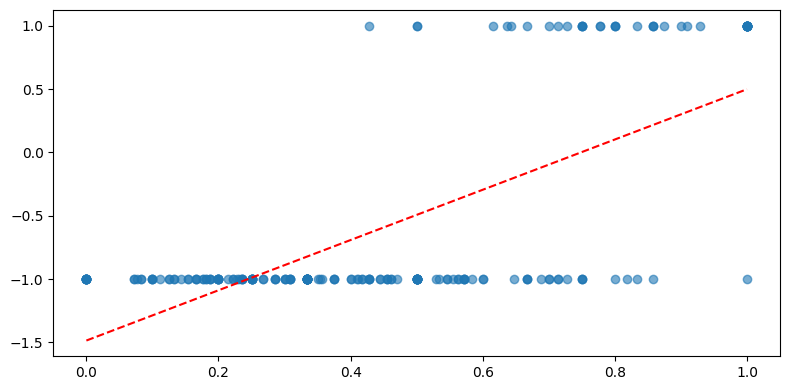

In [38]:
example_points = np.array([[1, X.min()], [1, X.max()]])
y_prediction = theta.T.dot(example_points.T)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(example_points[:,1], y_prediction[0], 'r--')
plt.tight_layout()
plt.show()

In [39]:
y_prediction

array([[-1.48534326,  0.49870501]])

### Other algorithm for gradient descent

Batch gradient descent is not the only option for training. In order to avoid exploring the whole dataset to estimate the gradients, have a look at two important options:
- **Stocastic Gradient Descent**: computes the gradient of the parameters using only a single or a few training items by sampling.
- **Mini-batch Gradient Descent**: used often in combination with SGD works of small subsets of the trainin items. Working on minibatches instead of single items reduces the variance in the parameter update and can lead to more stable convergence.

## Work with more features

Now, instead of trying to predict the class observing the number of cuisine-specific ingredients, we encode the recipe ingredients into one-hot encoding vectors in order to work with more features.

Note that the only thing that changes is the shape of the $\mathbf{X}$ matrix.

In [40]:
sample_size = 200
vocabulary = list(pd.Series(document_frequency).sort_values(ascending=False).head(100).keys().values)
X, y = np.zeros((sample_size, len(vocabulary))), np.ones((sample_size, 1))
for i, recipe in enumerate(train_json[:sample_size]):
    ingredients = recipe['ingredients']
    for ingredient in ingredients:
        try:
            X[i, vocabulary.index(ingredient)] = 1
        except ValueError:
            pass
    if recipe['cuisine'] != cuisine:
        y[i] = -1

In [41]:
Xb = np.c_[np.ones((X.shape[0], 1)), X]
Xb.shape

(200, 101)

In [42]:
eta = 0.1
iterations = 1000
m = Xb.shape[0]
theta = np.random.uniform(size=(Xb.shape[1], 1))
loss = []
history = []
for iteration in range(iterations):
    loss.append(mse(theta))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients
    if iteration % 20 == 0:
        history.append(theta)

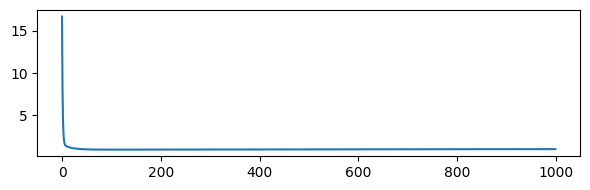

In [43]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(loss)
plt.tight_layout()
plt.show()

**note**: we use a transformation function (i.e., sign) to map predictions on binary labels

In [44]:
y_hat = theta.T.dot(Xb.T)[0]
np.sign(y_hat[:10])

array([-1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.])

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(Xb)

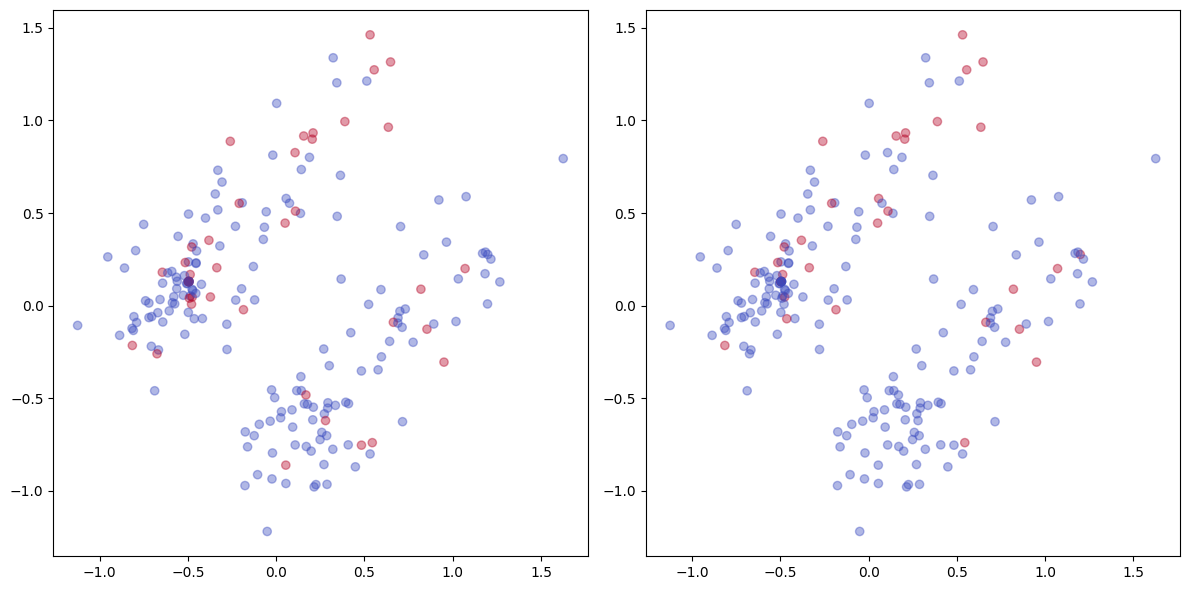

In [47]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].scatter(Xpca[:,0], Xpca[:,1], alpha=.4, c=y, cmap='coolwarm')
ax[1].scatter(Xpca[:,0], Xpca[:,1], alpha=.4, c=np.sign(y_hat), cmap='coolwarm')
plt.tight_layout()
plt.show()

### Evaluation for binary classification

In [48]:
import sklearn.metrics as mt

In [49]:
test_sample_size = 100
X_test, y_test = np.zeros((test_sample_size, len(vocabulary))), np.ones((test_sample_size, 1))
for i, recipe in enumerate(train_json[sample_size:sample_size + test_sample_size]):
    ingredients = recipe['ingredients']
    for ingredient in ingredients:
        try:
            X_test[i, vocabulary.index(ingredient)] = 1
        except ValueError:
            pass
    if recipe['cuisine'] != cuisine:
        y_test[i] = -1

In [50]:
Xb_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

In [51]:
y_pred = np.sign(theta.T.dot(Xb_test.T)[0])

In [52]:
print(mt.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.83      0.89      0.86        80
         1.0       0.36      0.25      0.29        20

    accuracy                           0.76       100
   macro avg       0.59      0.57      0.57       100
weighted avg       0.73      0.76      0.74       100



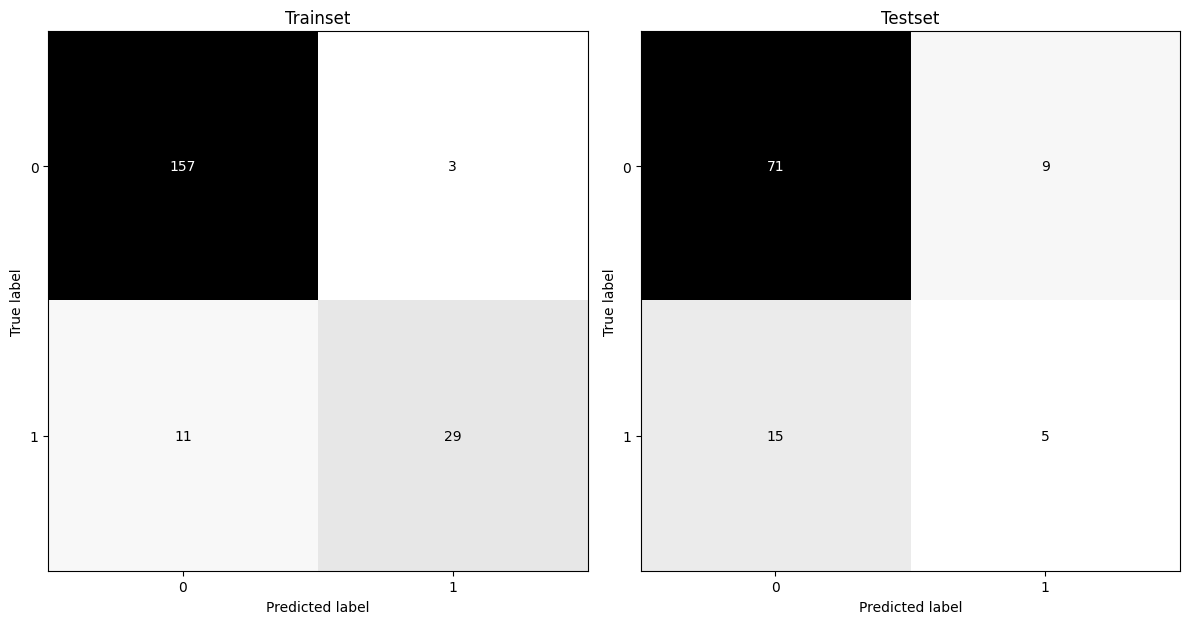

In [53]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
cmd_train = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y, np.sign(y_hat)))
cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_test, y_pred))
cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False)
cmd_test.plot(ax=ax[1], cmap='Greys', colorbar=False)
ax[0].set_title('Trainset')
ax[1].set_title('Testset')
plt.tight_layout()
plt.show()

### Learning rates on the training and the test set and the problem of overfitting

In [54]:
test_mse = lambda theta: np.power(theta.T.dot(Xb_test.T)[0] - y_test, 2).mean()

In [55]:
eta = 0.2
iterations = 5000
m = Xb.shape[0]
theta = np.random.uniform(size=(Xb.shape[1], 1))
loss, accuracy = [], []
test_loss, test_accuracy = [], []
for iteration in range(iterations):
    loss.append(mse(theta))
    test_loss.append(test_mse(theta))
    accuracy.append(mt.accuracy_score(y, np.sign(theta.T.dot(Xb.T)[0])))
    test_accuracy.append(mt.accuracy_score(y_test, np.sign(theta.T.dot(Xb_test.T)[0])))
    gradients = 2/m * Xb.T.dot(Xb.dot(theta) - y)
    theta = theta - eta * gradients

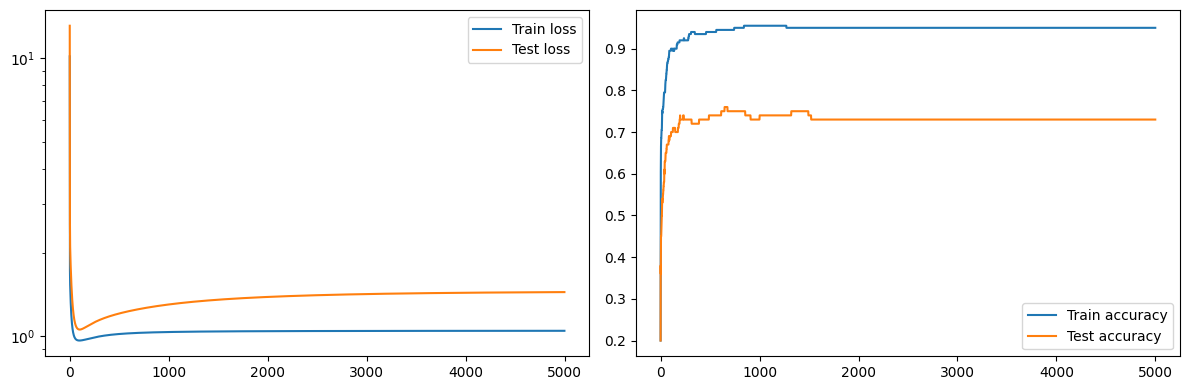

In [56]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].plot(loss, label='Train loss')
ax[0].plot(test_loss, label='Test loss')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].plot(accuracy, label='Train accuracy')
ax[1].plot(test_accuracy, label='Test accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

**Idea**. Use the mapping to categorical values in the training process.

## Logistic regression

The main idea of logistic regression is to estimate a probability for the target class as follows:

$$
\hat{p} = \sigma(\theta^T \cdot \mathbf{X})
$$

where $\sigma(\cdot)$ is a sigmoid function, such as:

$$
\sigma(j) = \frac{1}{1 + exp(-j)}
$$

The output $\hat{p}$ is interpreted as a probability that we can map on $\hat{y}$ as follows:

$$
\hat{y} = \Big\{  \begin{array}{ccc}
-1 & if & \hat{p} < 0.5 \\
1 & if & \hat{p} \geq 0.5
\end{array}
$$

### Loss function
The cost in training for an item can be estimated as (**log loss**):

$$
\ell(\theta) = \Big\{  \begin{array}{ccc}
-\log{\hat{p}} & if & y = 1 \\
-\log{1 - \hat{p}} & if & y = -1
\end{array}
$$

That is general is rewritten with $y \in {0, 1}$ as

$$
\ell(\theta) = - \frac{1}{m} \sum\limits_{i=1}^{m} \left[ y^{(i)} \log \left( \hat{p}^{(i)} \right) + 
(1 - y^{(i)}) \log \left( 1 - \hat{p}^{(i)} \right) \right]
$$

with partial derivates

$$
\frac{\partial}{\partial \theta_j} \ell(\theta) = \frac{1}{m} \sum\limits_{i=1}^{m} 
\left( \sigma \left( \theta^T - \mathbf{x}^{(i)} \right) - y^{(i)} \right) x_j^{(i)}
$$


In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
sample_size = 200
X, y = np.zeros((sample_size, 1)), np.ones((sample_size, 1))
for i, recipe in enumerate(train_json[:sample_size]):
    ingredients = recipe['ingredients']
    X[i,0] = len([x for x in ingredients if x in specific_ingredients]) / len(ingredients)
    if recipe['cuisine'] != cuisine:
        y[i] = 0

In [59]:
logistic = LogisticRegression()
logistic.fit(X, y.ravel())

LogisticRegression()

In [60]:
fake_data = np.linspace(0, 1, X.shape[0]).reshape(-1, 1)
probs = logistic.predict_proba(fake_data)

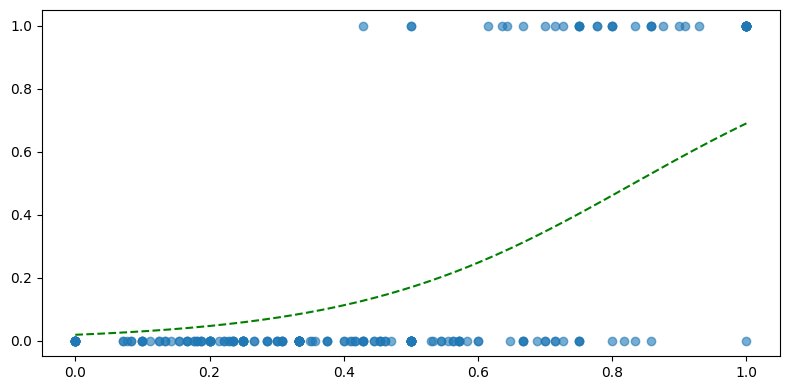

In [61]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(X, y, alpha=.6)
ax.plot(fake_data, probs[:,1], 'g--')
plt.tight_layout()
plt.show()

### A different vectorization process
We want to vectorize documents as vectors of the same size than classes
- for each recipe $x$ and for each ingredient $i$ we compute the probability of $i$ to be in all the classes.
- sum up the probability values per class
- create a vector over the classes for the recipe

In [62]:
sample_size = 200
class_vocabulary = list(cuisine_frequency.keys())
X, y = np.zeros((sample_size, len(class_vocabulary))), np.ones((sample_size, 1))
for i, recipe in enumerate(train_json[:sample_size]):
    ingredients = recipe['ingredients']
    prob_index = defaultdict(lambda: 0)
    for ingr in ingredients:
        for class_label in class_vocabulary:
            p_i = cuisine_frequency[class_label][ingredient] / sum(cuisine_frequency[class_label].values())
            prob_index[class_label] += p_i
    for class_label, score in prob_index.items():
        X[i, class_vocabulary.index(class_label)] = score
    if recipe['cuisine'] != cuisine:
        y[i] = 0

In [63]:
logistic = LogisticRegression()
logistic.fit(X, y.ravel())

LogisticRegression()

In [64]:
y_pred = logistic.predict(X)

In [65]:
print(mt.classification_report(y.ravel(), y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89       160
         1.0       0.00      0.00      0.00        40

    accuracy                           0.80       200
   macro avg       0.40      0.50      0.44       200
weighted avg       0.64      0.80      0.71       200



## Support Vector Machine (intuition)

The basic idea of SVM is to learn a prediction that is featured by the largest margin from the classes.

Recall that $\theta^T \mathbf{x} = 0$ (including the bias term) is the equation of the hiperplane that separates the data and that we can use the hyperplane for classification by computing

$$
\hat{y} = sign(\theta^T \mathbf{x})
$$

However, we can have several different hyperplanes which serve to the same goal by $\lambda \theta$ for $\lambda \in \mathbb{R}^{+}$. We can thus define a *canonical hyperplane* as the one that separates the point with a *functional distance* of at least 1.

$$
\mathbf{x}_i \cdot \theta \geq 1\ \textrm{if}\ y_i = 1 \newline
\mathbf{x}_i \cdot \theta \leq -1\ \textrm{if}\ y_i = -1 \newline
$$

or

$$
y_i(\mathbf{x}_i \cdot \theta) \geq 1
$$

Note that the notion of functional distance is referred to the resul value of the classification function, not to the geometric margin. The geomeric distance of the margin is given by:

$$
\frac{y_i(\mathbf{x}_i \cdot \theta)}{\mid\mid \theta \mid\mid} \geq \frac{1}{\mid\mid \theta \mid\mid}
$$

The goal of finding an optimal margin is thus to find a boundary that maximizes the geometric distance to the closest data points. This can be obtained by minimizing $\mid\mid \theta \mid\mid$.

In other terms, we want to minimize $\mid\mid \theta \mid\mid$ without violating the margin constraints $y_i(\mathbf{x}_i \cdot \theta) \geq 1$. Moreover, we express the minimization problem as follows:

$$
\textrm{minimize} \ \frac{1}{2} \theta^T \cdot \theta \newline
\textrm{subject to} \ y_i(\mathbf{x}_i \cdot \theta) \geq 1
$$

Note that we use $\frac{1}{2} \theta^T \cdot \theta$ instead of $\mid\mid \theta \mid\mid$ because it has a simple derivative.

### Online SVM
We can address the problem by gradient descent using the following loss function.

$$
\ell(\theta) = \frac{1}{2} \theta^T \cdot \theta + C \sum\limits_{i=1}^{m} \max\left( 0, 1 - y^{(i)} \left( \theta^T \mathbf{x}^{(i)} \right) \right)
$$
where $C$ is a hyperparameter for balancing. The first sum push the model to find a small $\theta$ to have a larger margin. The second sum compute the total of all margin violation. Minimizing this function means to find a large margin by minimizing the number of violations.

## Perceptron
We have seen how we can generalize the idea of linear classification by the following equation:

$$
\hat{y} = g(\theta^T \cdot \mathbf{X})
$$

where $g(\cdot)$ is a function that maps the predicted value to the target variable. This idea can be graphically represented as follows:

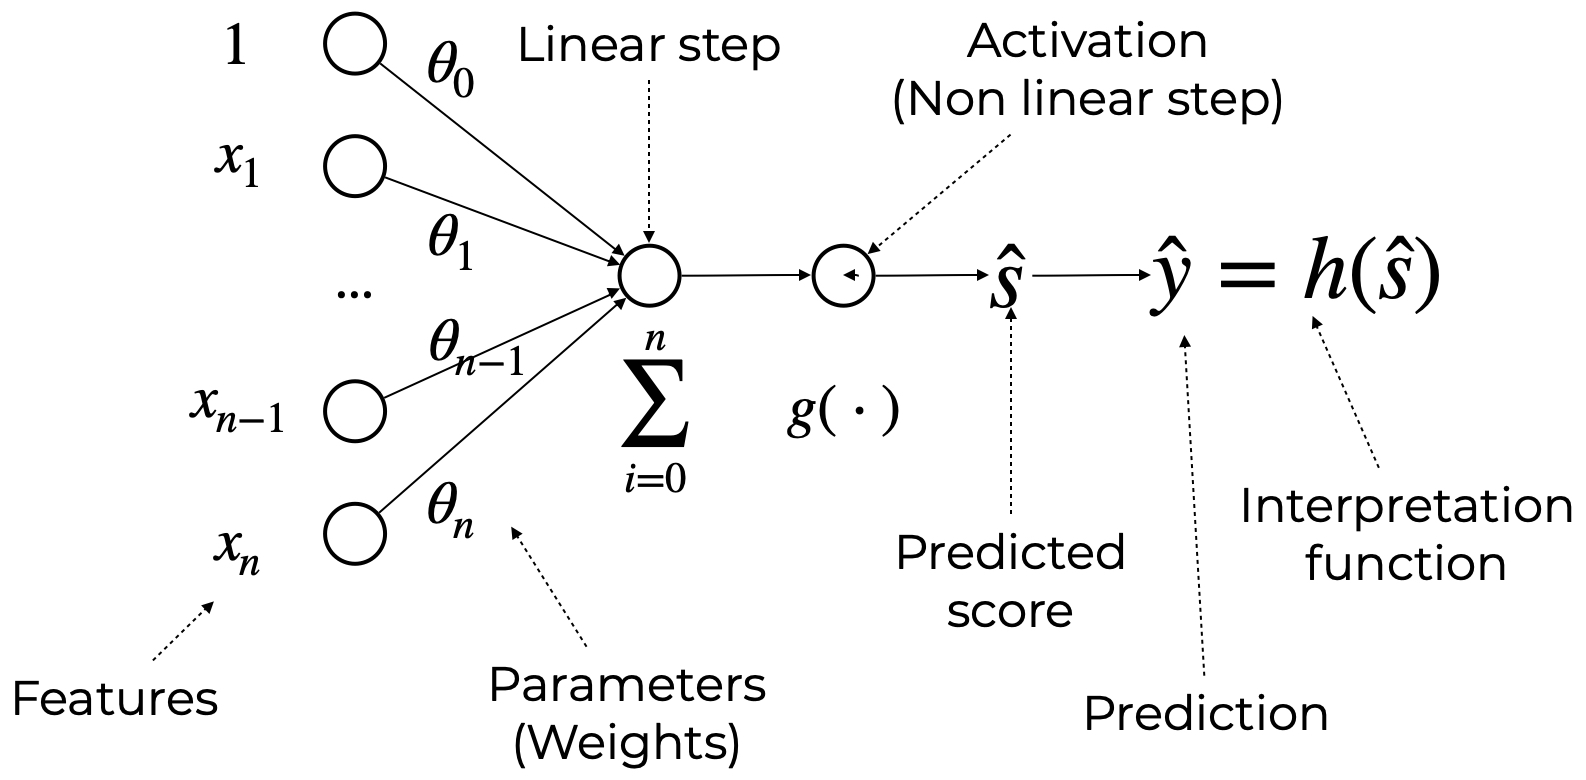

In [66]:
from IPython.display import Image
Image(filename='../imgs/perceptron.jpg')

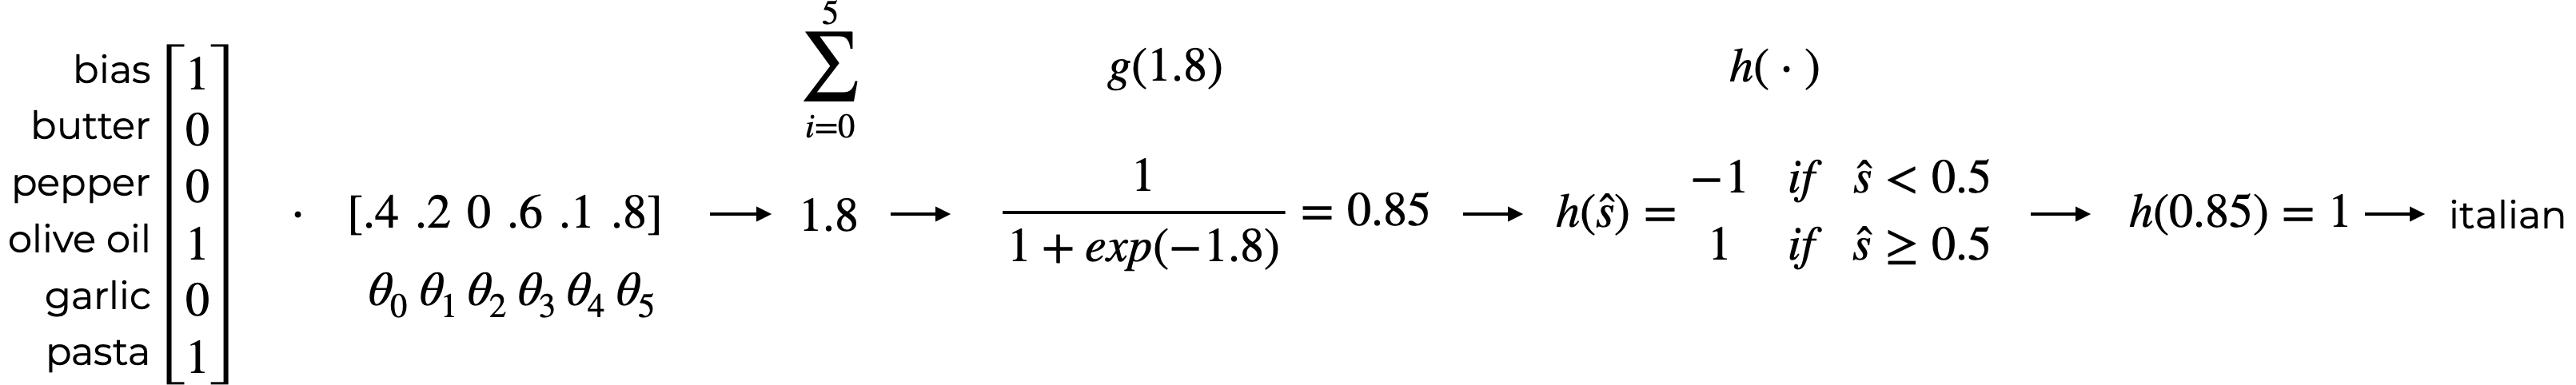

In [67]:
Image(filename='../imgs/perceptron-example.jpg')

## Neural networks
Perceptron can be easily generalized to handle multi-class problems as the in following image. Note that the only main change is in the dimensionality of $\theta$. Given $k$ classes, we will have $\theta \in \mathbb{R}^{n \times k}$. 

In [68]:
a = np.array([1,0,0,1,0,1])
th = np.array([.4, .2, 0, .6, .1, .8])
a.dot(th)

1.8

In [69]:
a = np.array([1,0,0,1,0,1])
th = np.array([[.4, .2, 0, .6, .1, .8], [.4, .2, 0, .6, .1, .0]])
a.dot(th.T)

array([1.8, 1. ])

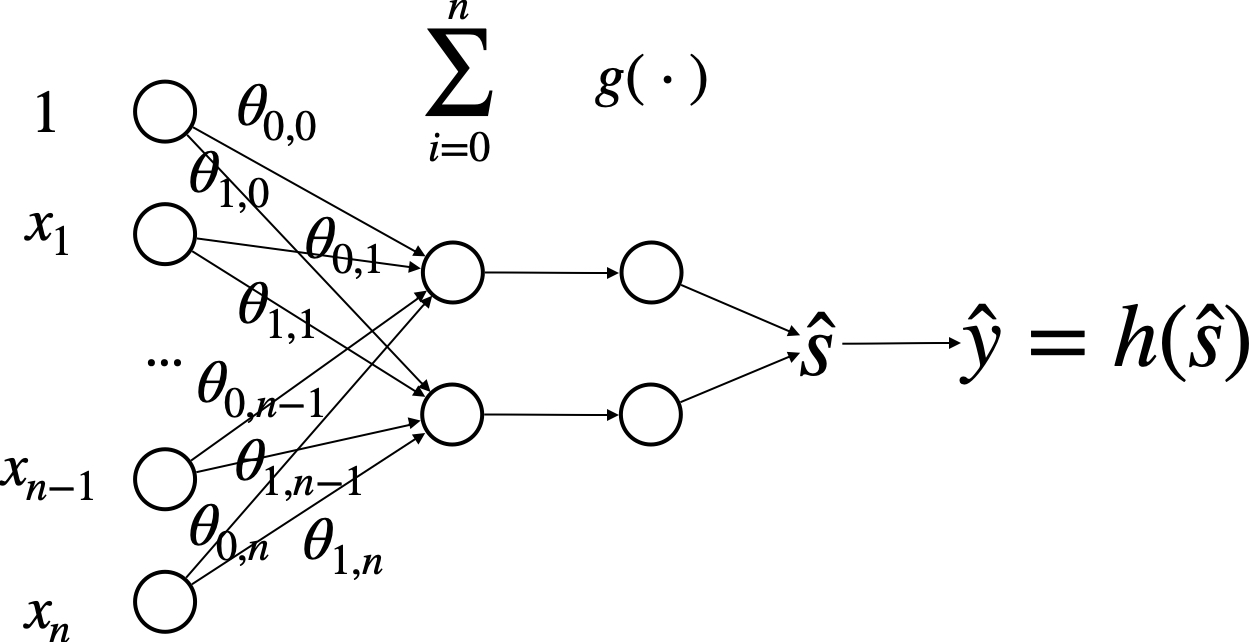

In [70]:
Image(filename='../imgs/ffn.jpg')

In [71]:
1 / (1 + np.exp(-np.array([1.8, 1])))

array([0.85814894, 0.73105858])

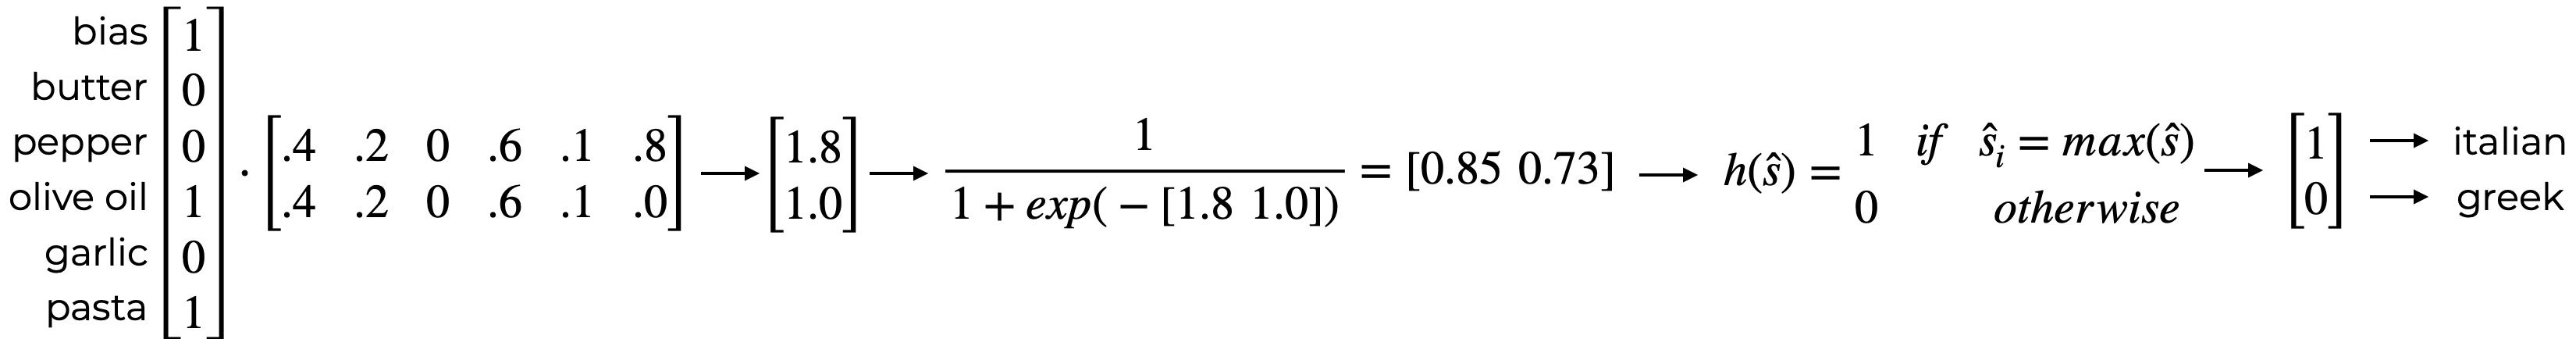

In [72]:
Image(filename='../imgs/ffn-example.jpg')

### Main activation functions

In [73]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
activation = {
    'identity': lambda x: x,
    'sign': lambda x: np.sign(x),
    'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
    'ReLU': lambda x: np.array([max([k, 0]) for k in x]),
    'tahn': lambda x: (np.exp(2*x) - 1) / (np.exp(2*x) + 1),
    'hard tahn': lambda x: np.array([max([min([k, 1]), -1]) for k in x])
}
data = np.linspace(-5, 5)

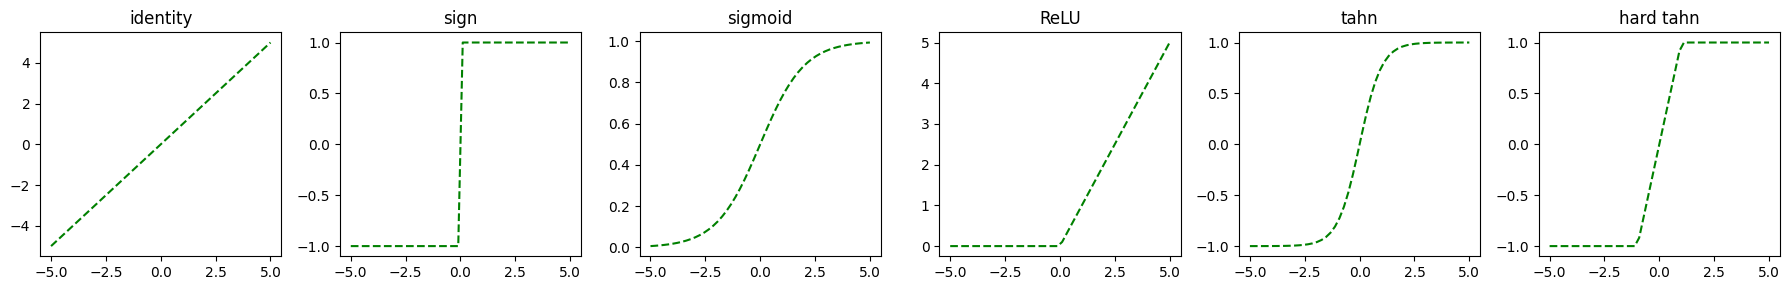

In [75]:
fig, ax = plt.subplots(figsize=(3*len(activation), 3), ncols=len(activation))
for i, (fun, f) in enumerate(activation.items()):
    ax[i].plot(data, f(data), 'g--')
    ax[i].set_title(fun)
plt.tight_layout()
plt.show()

### Simple feedforward network using PyTorch

Predict the cuisine given the combination of ingredients.

In [76]:
from sklearn.preprocessing import OneHotEncoder

In [77]:
train_data = train_json[:15000]
test_data = train_json[5000:6000]

In [78]:
vocabulary = list(pd.Series(document_frequency).sort_values(
    ascending=False).head(1000).keys().values)

In [79]:
enc_labels = OneHotEncoder(handle_unknown='ignore')

In [80]:
def get_data(data, vocabulary):
    features, labels = [], []
    for recipe in data:
        features.append([f for f in recipe['ingredients'] if f in vocabulary])
        labels.append([recipe['cuisine']])
    return features, labels

In [81]:
train_docs, train_labels = get_data(train_data, vocabulary)
test_docs, test_labels = get_data(test_data, vocabulary)

In [82]:
train_docs[:2]

[['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles'],
 ['plain flour',
  'ground pepper',
  'salt',
  'tomatoes',
  'ground black pepper',
  'thyme',
  'eggs',
  'green tomatoes',
  'yellow corn meal',
  'milk',
  'vegetable oil']]

In [83]:
train_labels[:2]

[['greek'], ['southern_us']]

In [84]:
X_train = np.zeros((len(train_docs), len(vocabulary)))
for i, doc in enumerate(train_docs):
    for ingredient in doc:
        X_train[i, vocabulary.index(ingredient)] = 1
y_train = enc_labels.fit_transform(np.array(train_labels)).toarray()

In [85]:
X_test = np.zeros((len(test_docs), len(vocabulary)))
for i, doc in enumerate(test_docs):
    for ingredient in doc:
        X_test[i, vocabulary.index(ingredient)] = 1
y_test = enc_labels.transform(np.array(test_labels)).toarray()

### Torch data loader

In [86]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [87]:
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=10)

In [88]:
for (x, y) in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([10, 1000]) torch.Size([10, 20])


In [89]:
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=10)

### The simple Net

In [90]:
import torch.nn as nn
import torch.nn.functional as F

In [91]:
class SimpleNet(nn.Module):

    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = F.softmax(self.fc(x), dim=0)
        return x

In [92]:
net = SimpleNet(X_train.shape[1], y_train.shape[1])

In [93]:
for (x, y) in train_dataloader:
    p = net(x)
    break

In [94]:
p.shape

torch.Size([10, 20])

In [95]:
p[0]

tensor([0.1054, 0.1008, 0.0998, 0.1068, 0.0979, 0.0998, 0.0929, 0.0924, 0.1006,
        0.0909, 0.0990, 0.1067, 0.0988, 0.1066, 0.0947, 0.1053, 0.1018, 0.1053,
        0.0988, 0.1013], grad_fn=<SelectBackward0>)

### Train

In [96]:
import time
import math

In [97]:
batches = [(doc, lab) for doc, lab in train_dataloader]
read_labels = [x.replace('x0_', '') for x in enc_labels.get_feature_names_out()]

In [98]:
def train(document_tensor, label_tensor):
    net.zero_grad()
    output = net(document_tensor)
    loss = criterion(output, label_tensor)
    loss.backward()

    for p in net.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [99]:
n_iters = 20000
print_every = 2000
plot_every = 200
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.1

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

epochs = list(range(1, n_iters + 1))
for it in tqdm(epochs):
    document_tensor, label_tensor = batches[np.random.randint(0, len(batches) - 1)]
    output, loss = train(document_tensor, label_tensor)
    current_loss += loss

    if it % print_every == 0:
        preds = torch.argmax(output, dim=1)
        ground = torch.argmax(label_tensor, dim=1)
        for i, p in enumerate(preds[:3]):
            g = ground[i]
            print('{} ==> {}'.format(read_labels[p], read_labels[g]))

    if it % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  0%|          | 0/20000 [00:00<?, ?it/s]

italian ==> korean
french ==> korean
spanish ==> mexican
vietnamese ==> korean
greek ==> cajun_creole
korean ==> korean
jamaican ==> mexican
southern_us ==> french
chinese ==> chinese
italian ==> moroccan
italian ==> southern_us
chinese ==> korean
southern_us ==> southern_us
chinese ==> japanese
chinese ==> chinese
mexican ==> mexican
italian ==> cajun_creole
italian ==> italian
cajun_creole ==> mexican
southern_us ==> indian
filipino ==> southern_us
chinese ==> southern_us
mexican ==> mexican
southern_us ==> southern_us
italian ==> french
chinese ==> mexican
southern_us ==> southern_us
mexican ==> mexican
french ==> italian
southern_us ==> southern_us


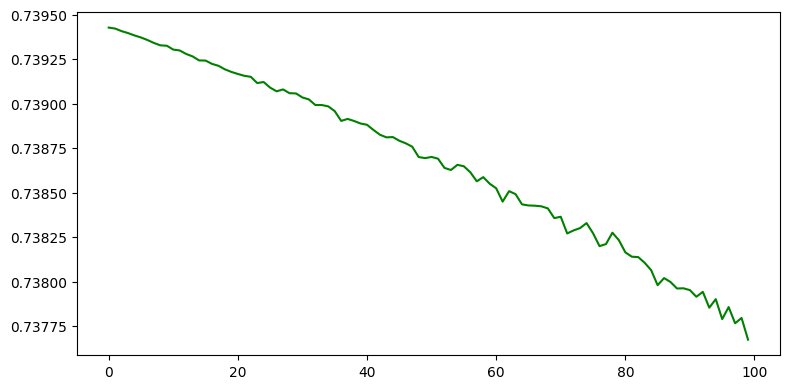

In [100]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(all_losses, 'g')
plt.tight_layout()
plt.show()

### Prediction on train

In [101]:
y_pred_train, y_true_train = [], []
for doc, lab in train_dataloader:
    output = net(doc)
    preds = torch.argmax(output, dim=1)
    ground = torch.argmax(lab, dim=1)
    for i, p in enumerate(preds):
        y_pred_train.append(p)
        g = ground[i]
        y_true_train.append(g)

In [102]:
print(mt.classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.12      0.05      0.07       178
           1       0.02      0.00      0.01       313
           2       0.56      0.31      0.40       601
           3       0.39      0.83      0.53      1015
           4       0.10      0.04      0.05       273
           5       0.30      0.14      0.19       987
           6       0.42      0.10      0.17       433
           7       0.52      0.72      0.61      1084
           8       0.07      0.02      0.03       245
           9       0.58      0.68      0.63      2965
          10       0.16      0.06      0.08       208
          11       0.34      0.18      0.24       545
          12       0.19      0.04      0.06       330
          13       0.69      0.73      0.71      2425
          14       0.38      0.08      0.13       287
          15       0.10      0.03      0.05       186
          16       0.35      0.59      0.44      1646
          17       0.15    

### Prediction on test

In [103]:
y_pred, y_true = [], []
for doc, lab in test_dataloader:
    output = net(doc)
    preds = torch.argmax(output, dim=1)
    ground = torch.argmax(lab, dim=1)
    for i, p in enumerate(preds):
        y_pred.append(p)
        g = ground[i]
        y_true.append(g)

In [104]:
print(mt.classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.20      0.11      0.14         9
           1       0.00      0.00      0.00        16
           2       0.60      0.28      0.38        43
           3       0.36      0.84      0.50        62
           4       0.43      0.17      0.24        18
           5       0.25      0.13      0.17        71
           6       0.25      0.08      0.12        24
           7       0.52      0.73      0.61        81
           8       0.00      0.00      0.00        16
           9       0.53      0.67      0.59       187
          10       0.33      0.07      0.11        15
          11       0.30      0.08      0.12        38
          12       0.00      0.00      0.00        24
          13       0.67      0.71      0.69       149
          14       0.50      0.09      0.15        23
          15       0.00      0.00      0.00        14
          16       0.35      0.57      0.43       111
          17       0.33    

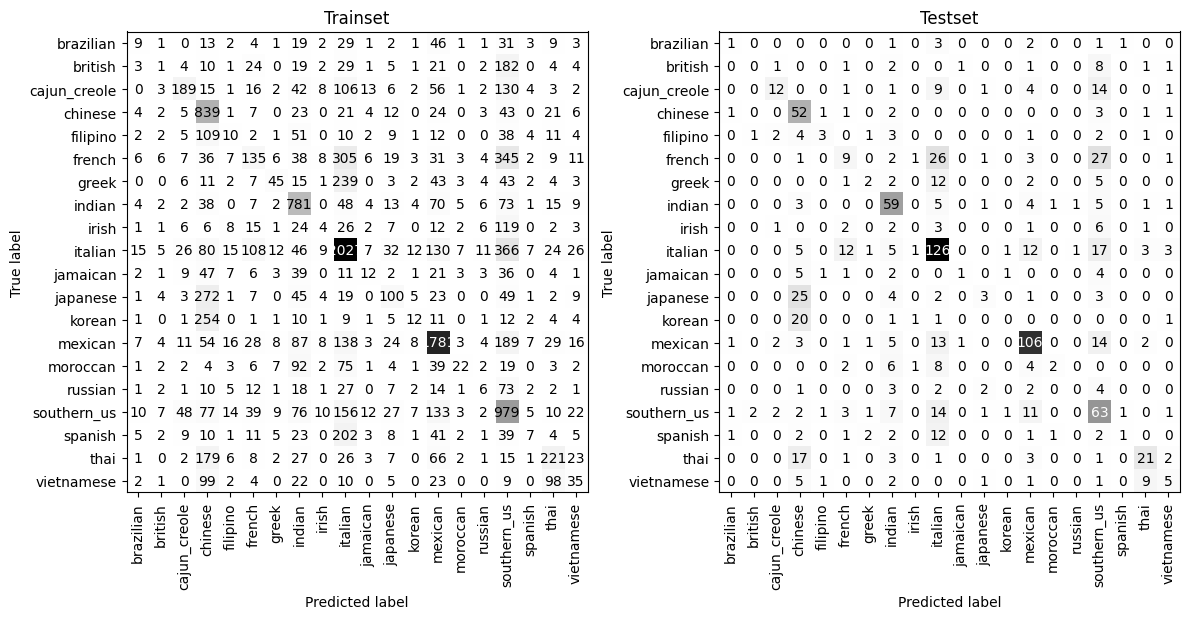

In [105]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
cmd_train = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_true_train, y_pred_train), 
                                    display_labels=read_labels)
cmd_test = mt.ConfusionMatrixDisplay(confusion_matrix=mt.confusion_matrix(y_true, y_pred), 
                                    display_labels=read_labels)
cmd_train.plot(ax=ax[0], cmap='Greys', colorbar=False, xticks_rotation='vertical')
cmd_test.plot(ax=ax[1], cmap='Greys', colorbar=False, xticks_rotation='vertical')
ax[0].set_title('Trainset')
ax[1].set_title('Testset')
plt.tight_layout()
plt.show()